# Tutorial 1: Training a spiking neural network with surrogate gradients

Friedemann Zenke (https://fzenke.net)

## Introduction 

The last months have seen a surge of interest in training spiking neural networks to do meaningful computations. On the one hand, this surge was fueled by the limited accomplishment of more traditional, and often considered more biologically plausible, learning paradigms in creating functional neural networks which solve interesting computational problems. This limitation was met by the undeniable success of deep neural networks in acing a diversity of challenging computational problems. A success, that has raised both the bar and the question of how well this progress would translate to spiking neural networks.

The rise of deep learning over the last decade is in large part due to GPUs and their increased computational power, growing training data sets, and --- perhaps most importantly --- advances in understanding the quirks and needs of the error back-propagation algorithm. For instance, we now know that we have to avoid vanishing and exploding gradients, a feat that can be accomplished by choice of a sensible nonlinearity, proper weight initialization, and a suitable optimizer. Powerful software packages supporting auto-differentiation have since made mangling with deep neural networks a breeze in comparison to what it used to be. This begs the question of how much of this knowledge gain from deep learning and its tools we can leverage to train spiking neural networks. Although a complete answer to this questions cannot be given at the moment, it seems that we can learn a lot.

In this tutorial we use insights and tools from machine learning to build step-by-step a spiking neural network. Specifically, we set out with the goal of building a spiking network model which solves a real-world problem. To that end, we focus on a simple classification problem and use supervised learning in conjunction with aforementioned back-propagation of error. To do this, we have to overcome yet another vanishing gradient problem linked to the binary nature of the spikes themselves.

In this tutorial, we will first show how a simple feed-forward spiking neural network of leaky integrate-and-fire (LIF) neurons with current-based synapses can be formally mapped to discrete time recurrent neural network (RNN). We will used this formulation to explain why gradients vanish at spikes and show one way of how the problem can be alleviated. Specifically, we will introduce surrogate gradients and provide practical examples of how they can be implemented in PyTorch.

## Mapping LIF neurons to RNN dynamics

The de facto standard neuron model for network simulations in computational neuroscience is the LIF neuron model which is often formally written as a time continuous dynamical system in differential form:
$$\tau_\mathrm{mem} \frac{\mathrm{d}U_i}{\mathrm{d}t} = -(U_i-U_\mathrm{rest}) + RI_i$$
where $U_i$ is the membrane potential of neuron $i$, $U_\mathrm{rest}$ is the resting potential, $\tau_\mathrm{mem}$ is the membrane time constant, $R$ is the input resistance, and $I_i$ is the input current. The membrane potential $U_i$ characterizes the hidden state of each neuron and, importantly, it is not directly communicated to downstream neurons. However, a neuron fires an action potential or spike at the time $t$ when its membrane voltage exceeds the firing threshold $\vartheta$. After having fired a spike, a neurons membrane voltage is reset $U_i \rightarrow U_\mathrm{rest}$. We write
$$S_i(t)=\sum_k \delta(t-t_j^k)$$ for the spike train (ie. the sum of all spikes) emitted by neuron $i$. Here $\delta$ is the Dirac delta function and $t_i^k$ are the associated firing times of neuron $i$.

Spikes travel down the axon and generate a postsynaptic currents in connected neurons. Using our above formalism we can thus write
$$\frac{\mathrm{d}I_i}{\mathrm{d}t}= -\frac{I_i(t)}{\tau_\mathrm{syn}} + \sum_j W_{ij} S_j(t)$$
where we have introduced the synaptic weight matrix $W_{ij}$ and the synaptic decay time constant $\tau_\mathrm{syn}$.

To make the link to RNNs apparent, we will now express above equations in discrete time. For brevity we now set the following natural units $U_\mathrm{rest}=0$, $R=1$, and $\vartheta=1$. Our arguments remain unaffected by this choice and all results can always be re-scaled back to physical units. To highlight the nonlinear character of a spike we start by noting that we can set
$$S_i(t)=\Theta(U_i(t)-\vartheta)$$
where $\Theta$ denotes the Heaviside step function.

Assuming a small simulation time step of $\Delta_t>0$ we can approximate the synaptic dynamics by
$$I_i(t+1) = \alpha I_i(t) + \sum_j W_{ij} S_j(t)$$
with the decay constant $\alpha=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{syn}} \right)$. Further, the membrane dynamics can be written as
$$U_i(t+1) = \underbrace{\beta U_i(t)}_{\mathrm{leak}} + \underbrace{I_i(t)}_{\mathrm{synaptic}} -\underbrace{S_i(t)}_{\mathrm{reset}}$$
with $\beta=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{mem}}\right)$. Note the distinct terms on the right-hand-side of the equation which are responsible individually for i) leak, ii) synaptic input, and iii) the spike reset.



These equations now make the RNN character of the spiking neurons apparent. Their action can be summarized in a RNN computational graph. 
<img src="figures/snn_graph/snn_graph.png" width="450">
Time flows from left to right. Inputs enter the network at each time step from the bottom of the graph ($x$). These inputs sequentially influence the synaptic currents $I_i$, membrane potentials the $U_i$, and finally the spiking output $S_i$.  Moreover, dynamic quantities have a direct input on future time steps. We have suppressed the indices $i$ in the figure for clarity. All quantities can be thought of as vector quantities.

Because the above expressions can be unrolled in time and as such should be amenable to network training using back-propagation through time (BPTT). We will discuss problems arising from the binary character of the spiking nonlinearity later. For now let us  start by implementing the above dynamics in a three layer spiking neural network in PyTorch.

## Example network

<img src="figures/mlp_sketch/mlp_sketch.png">

Let's start with a simple multilayer network model with a single hidden layer as shown above. For the sake of argument we set the numbers for the input, hidden and output neurons as follows:

In [1]:
nb_inputs  = 100
nb_hidden  = 4
nb_outputs = 2

As we have seen above, we are technically simulating an RNN. Thus we have to simulate our neurons for a certain number of timesteps. We will use 1ms timesteps and we want to simulate our network for say 200 timesteps. 

In [2]:
time_step = 1e-3
nb_steps  = 200

To take advantange of parallelism we will set up our code to work on batches of data like this is usually done for neural networks which are trained in a supervised manner.
To that end, we specify a batch size here.

In [3]:
batch_size = 256

With these basic design choices made, we can now start building the actual network. Here we will be using PyTorch, but you will be able to reproduce these results in most common machine learning libraries.

We start by importing the libraries we need.

In [4]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
# import torchvision

In [5]:
dtype = torch.float
device = torch.device("cpu")

# Uncomment the line below to run on GPU
# device = torch.device("cuda:0") 

### A simple synthetic dataset 

We start out by generating some random spiking data set which we will use as input to our network. In the beginning we will work with a single batch of data. It will be straight forward to later expand what we have learned to larger datasets.

Suppose we want our network to classify a set of different sparse input spike trains into two categories. 

To generate some synthetic data we fill a tensor of (batch_size x nb_steps x nb_inputs) with random uniform numbers between 0 and 1 and use this to generate our input dataset:

In [6]:
freq = 5 # Hz
prob = freq*time_step
mask = torch.rand((batch_size,nb_steps,nb_inputs), device=device, dtype=dtype)
x_data = torch.zeros((batch_size,nb_steps,nb_inputs), device=device, dtype=dtype, requires_grad=False)
x_data[mask<prob] = 1.0

If the plot the spike raster of the first input pattern this synethic dataset it looks as follows.

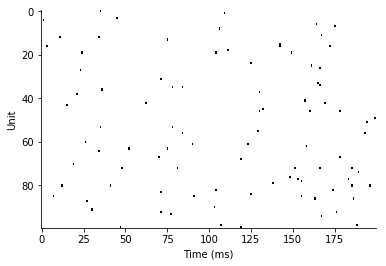

In [7]:
data_id = 0
plt.imshow(x_data[data_id].t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

Next we assign a random label of 0 or 1 to each of our input patterns. Our network's task will be to differentiate these patterns.

In [8]:
y_data = torch.tensor(1*(np.random.rand(batch_size)<0.5), device=device)

Note that there is no structure in the data (because it is completely random). Thus we won't worry about generalization now and only care about our ability to overfit these data with the spiking neural network we are going to build in a jiffy.

### Setup of the spiking network model

Now is the time to implement our LIF neuron model in discrete time.
We will first do this step by step before we wrap all the steps into a function later on.
But first we first fix several model constants such as the membrane and the synaptic time constant. Moreover, we define some helpful variables including our $\alpha$ and $\beta$ as define above. We do this now because we will use some of these variables to scale our weights to meaningful ranges.

In [9]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

Now we set up our weight matrices which connect the input and the hidden layer, as well as the matrix connecting the hidden layer with the output layer. Moreover, we initialize these weights randomly from a normal distribution. Note that we scale the variance with the inverse square root of the number of input connections. Moreover, for the sake of simplicity we ignore Dale's law in this tutorial, thus weights can be either excitatory or inhibitory. This choice is common in artificial neural networks.

In [10]:
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


### A spiking neuron model in discrete time

The first thing we need to do to implement our spiking neuron is to multiply all input spikes with the weight matrix. We have to do this for each time step in each input example in the batch. Because we have stored our input spikes in a rank 3 tensor we can express this operation in a single line:

In [11]:
h1 = torch.einsum("abc,cd->abd", (x_data, w1))

These "weighted" input spikes will now feed into our synaptic variable and ultimately the membrane potential. To trigger a spike we need to moreover define a threshold or spike function which we do in the following. We will later have to slightly alter this definition to actually train the network, but more about that later.

### The spiking nonlinearity (the naive way)

In discrete time, as explained earlier, we can formulate our spiking nonlinearity as a Heaviside step function. So let's begin with defining a Heaviside function. One way of implementing it is the following:

In [12]:
def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out

For each trial we initialize the synaptic currents and membrane potentials at zero.
Next we need to implement a loop which simulates our neuron models over time. 
Moreover, we will record the membrane potentials and output spikes of all trials and all neurons.

In [13]:
syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

# Here we define two lists which we use to record the membrane potentials and output spikes
mem_rec = [mem]
spk_rec = [mem]

# Here we loop over time
for t in range(nb_steps):
    mthr = mem-1.0
    out = spike_fn(mthr)
    rst = torch.zeros_like(mem)
    c = (mthr > 0)
    rst[c] = torch.ones_like(mem)[c]
    
    new_syn = alpha*syn +h1[:,t]
    new_mem = beta*mem +syn -rst
    
    mem = new_mem
    syn = new_syn
    
    mem_rec.append(mem)
    spk_rec.append(out)

# Now we merge the recorded membrane potentials into a single tensor
mem_rec = torch.stack(mem_rec,dim=1)
spk_rec = torch.stack(spk_rec,dim=1)

And that's it. The above loop has now simulated our neurons for '''nb_steps''' and stored their membrane traces and output spikes. Let us take a look at those membrane potentials in which we directly "paste" the spikes for visual inspection. We will directly plot multiple trials at once and dfine a little helper function for this purpose.

In [14]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = (mem+spike_height*spk).detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

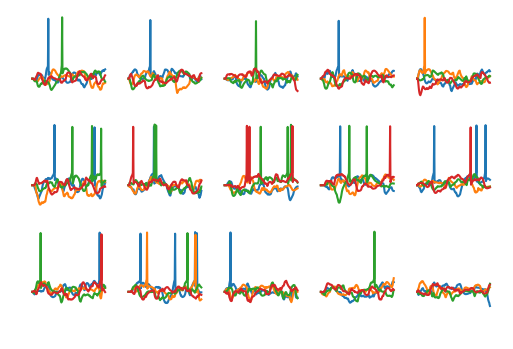

In [15]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

As you can see our random initialization gives us some sporadic spiking. Thus far, we have only an input layer and a spiking layer which should become our hidden layer. Next, we will have to add a readout layer to our network.

## Adding a readout layer

To use our network as a classifier we need to have a readout layer on whose output we can define a cost function. There are several possibilities of doing this. For instance, we could count output layer spikes, or we could directly define an objective function on the membrane potential of the output neurons. Here we will follow the latter approach, but keep in mind that there are many other possibilities of defining an output layer and respective cost functions on them.

In the following we will build the output layer as a population of leaky integrator neurons. The reason for this choice is that leaky integration is the natural way of how neurons receive the spiking output of their bretheren. Moreover, because we will need this code again we combine our code from above plus the added readout layer into a single function.

In [16]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = [mem]
    spk_rec = [mem]

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c   = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]

        new_syn = alpha*syn +h1[:,t]
        new_mem = beta*mem +syn -rst

        mem = new_mem
        syn = new_syn

        mem_rec.append(mem)
        spk_rec.append(out)

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

We can now run this code and plot the output layer "membrane potentials" below. As desired these potentials do not have spikes riding on them.

In [17]:
out_rec,other_recs = run_snn(x_data)

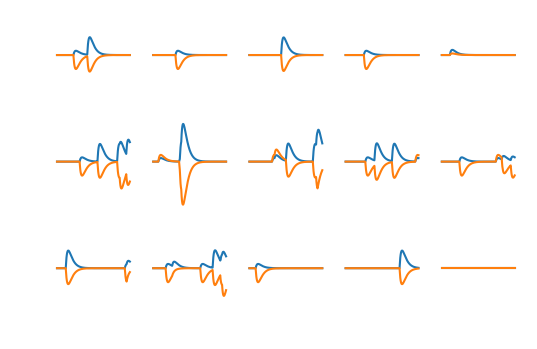

In [18]:
fig=plt.figure(dpi=100)
plot_voltage_traces(out_rec)

By preventing the output neurons from spiking themselves we can define a relatively smooth objective on their membrane voltages directly. Specifically, we use the maximum voltage over time of each output unit
$$\hat U^\mathrm{out}_i=\max_t U^\mathrm{out}_i(t)$$
and then use this vector as input for either an argmax to compute the classification accuracy or as we will see below as input for a standard softmax function in conjunction with a negative log likelihood loss for optimizing the weights in the network. 

Let us first compute the classification accuracy of this random network. We will see that this accuracy is somewhere around 50% as it should be since that corresponds the the chance level of our synthetic task.

In [19]:
def print_classification_accuracy():
    """ Dirty little helper function to compute classification accuracy. """
    output,_ = run_snn(x_data)
    m,_= torch.max(output,1) # max over time
    _,am=torch.max(m,1) # argmax over output units
    acc = np.mean((y_data==am).detach().cpu().numpy()) # compare to labels
    print("Accuracy %.3f"%acc)
    
print_classification_accuracy()

Accuracy 0.484


## Supervised learning

So far we have build the infrastructure to simulate our spiking neural network, but we have worked with purely random network weights thus far.
The vanilla method to adjust network weights to descrease the specified objective is gradient descent. 
Machine learning libraries like Tensorflow and PyTorch make implementing gradient descent a breeze.
We first perform gradient descent on the true gradient and use this as a motivation for introducing surrogate gradients.
Here we go.

### Supervised learning with the true gradient

In [20]:
params = [w1,w2] # The paramters we want to optimize
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999)) # The optimizer we are going to use

log_softmax_fn = nn.LogSoftmax(dim=1) # The log softmax function across output units
loss_fn = nn.NLLLoss() # The negative log likelihood loss function

# The optimization loop
loss_hist = []
for e in range(1000):
    # run the network and get output
    output,_ = run_snn(x_data) 
    # compute the loss
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m) 
    loss_val = loss_fn(log_p_y, y_data)

    # update the weights
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    
    # store loss value
    loss_hist.append(loss_val.item())
    
loss_hist_true_grad = loss_hist # store for later use

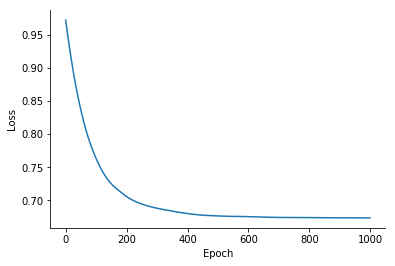

In [21]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [22]:
print_classification_accuracy()

Accuracy 0.559


We appreciate that loss decreases over iterations and converges towards a steady state. The classification accuracy, however, does not seem to improve dramatically over the course of the optimization. What a shame! 

The underlying reason is that the nonlinearity of the hidden units has zero derivative everywhere except at threshold crossing where it becomes infinite. In practice that means that weight updates in the hidden layer vanish and the weights remain unmodified. By plotting the hidden layer activations and comparing them by what wh have plotted before we will see that these activations have not changed at all. Thus no learning happens in the hidden layer. The reason why the loss decreased initially during optimization is that the output layer weights could still change and allow for some improvement (even if it was very little).

To improve performance we need to get the hidden layer units to take part in learning. To achieve this we will introduce a surrogate gradient in the next section.

In [23]:
output,other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

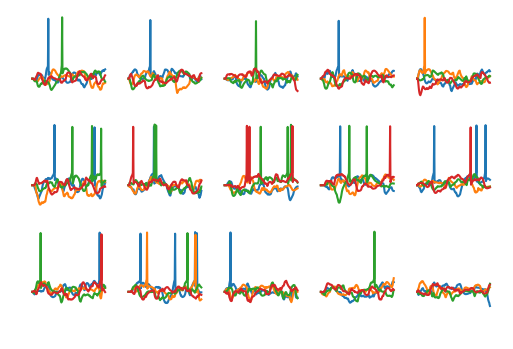

In [24]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

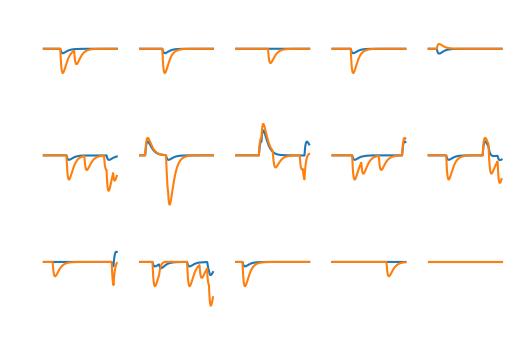

In [25]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

### Supervised learning with surrogate gradients

In the last section we saw that the hidden layer units did not participate in.
The underlying reason is that the partial derivative of the step function we used has zero derivative everywhere (except at zero where it becomes infinite).

Most conventional neural networks avoid this problem by chosing a nonlinearity with nonzero partial derivative. For instance, sigmoidal or tanh units were common during the beginnings of neural networks research. Today, ReLU are more common. Importantly, all these activation functions have substantial non-zero support which allows gradients to flow (to greater or lesser extent).

What do we if we want to stick to our binary nonlinearity? There have been several approaches to tackle this problem. Here we use one such approach which has been applied successfully to spiking neural networks: We use a surrogate gradient approach.

The idea behind a surrogate gradient is dead simple. Instead of changing the nonlinearity itself, we only change the gradient. Thus we use a different "surrogate" gradient to optimize paramters which would otherwise have a vanishing gradient.

<img src="figures/surrgrad/surrgrad.png" width="450">
Specifically, we use the partial derivative of a function which to some extent approximates the stepfunction $\Theta(x)$.
In what follows, specifically, we will use (up to rescaling) the partial derivative of a fast sigmoid function $\sigma(x)$. 
While $\Theta$ is invariant to multiplicative rescaling, $\sigma$ isn't. Thus we have to introduce a scale parameter.

In [26]:
class SuperSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SuperSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SuperSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SuperSpike.apply

In [27]:
# To reinitialize the weights uncomment the following lines
# torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
# torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
# print("init done")

In [28]:
params = [w1,w2]
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999))

log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

loss_hist = []
for e in range(1000):
    output,_ = run_snn(x_data)
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m)
    loss_val = loss_fn(log_p_y, y_data)

    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    loss_hist.append(loss_val.item())

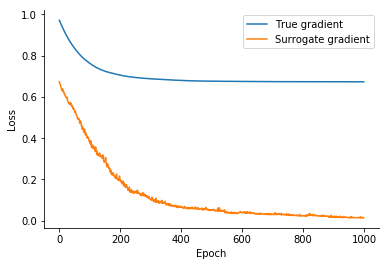

In [29]:
plt.plot(loss_hist_true_grad, label="True gradient")
plt.plot(loss_hist, label="Surrogate gradient")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
sns.despine()

In [30]:
output,other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

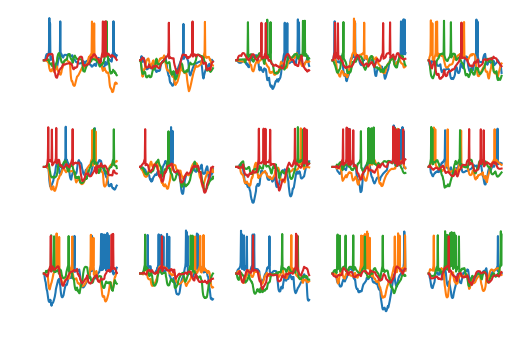

In [31]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

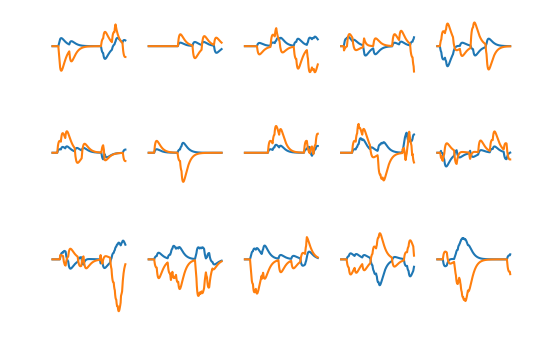

In [32]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

In [33]:
output,_ = run_snn(x_data)
m,_=torch.max(output,1)

# Compute training accuracy
_,am=torch.max(m,1)
acc = np.mean((y_data==am).detach().cpu().numpy())
print("Accuracy %f"%acc)

Accuracy 0.996094
